In [1]:
# download nltk stopwords
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import make_interp_spline
import matplotlib.patches as patches
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\דניאלה\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Testing your app

Once your app is running you can query it. You can simply do that by clicking on the URL printed above (the one looking like https://XXXXX-5000-colab.googleusercontent.com/search?query=hello+world or by issuing an HTTP request through code (from colab).

The code below shows how to issue a query from python. This is also how our testing code will issue queries to your search engine, so make sure to test your search engine this way after you deploy it to GCP and before submission. Command line instructions for deploying your search engine to GCP are available at `run_frontend_in_gcp.sh`. Note that we will not only issue training queries to your search engine, but also test queries, i.e. queries that you've never seen before.

In [2]:
with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

In [3]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [4]:
def precision_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(predicted_list) == 0:
        return 0.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(predicted_list), 3)
def recall_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(true_set) < 1:
        return 1.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(true_set), 3)
def f1_at_k(true_list, predicted_list, k):
    p = precision_at_k(true_list, predicted_list, k)
    r = recall_at_k(true_list, predicted_list, k)
    if p == 0.0 or r == 0.0:
        return 0.0
    return round(2.0 / (1.0/p + 1.0/r), 3)
def results_quality(true_list, predicted_list):
    p5 = precision_at_k(true_list, predicted_list, 5)
    f1_30 = f1_at_k(true_list, predicted_list, 30)
    if p5 == 0.0 or f1_30 == 0.0:
        return 0.0
    return round(2.0 / (1.0/p5 + 1.0/f1_30), 3)

assert precision_at_k(range(10), [1,2,3] , 2) == 1.0
assert recall_at_k(   range(10), [10,5,3], 2) == 0.1
assert precision_at_k(range(10), []      , 2) == 0.0
assert precision_at_k([],        [1,2,3],  5) == 0.0
assert recall_at_k(   [],        [10,5,3], 2) == 1.0
assert recall_at_k(   range(10), [],       2) == 0.0
assert f1_at_k(       [],        [1,2,3],  5) == 0.0
assert f1_at_k(       range(10), [],       2) == 0.0
assert f1_at_k(       range(10), [0,1,2],  2) == 0.333
assert f1_at_k(       range(50), range(5), 30) == 0.182
assert f1_at_k(       range(50), range(10), 30) == 0.333
assert f1_at_k(       range(50), range(30), 30) == 0.75
assert results_quality(range(50), range(5))  == 0.308
assert results_quality(range(50), range(10)) == 0.5
assert results_quality(range(50), range(30)) == 0.857
assert results_quality(range(50), [-1]*5 + list(range(5,30))) == 0.0


In [ ]:
import math

def ndcg_at_k(true_list, predicted_list, k=100):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    
    dcg = 0.0
    for i, doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            dcg += 1.0 / math.log2(i + 2)
            
    num_relevant_items = len(true_set)
    
    n_ideal = min(k, num_relevant_items)
    
    idcg = 0.0
    for i in range(n_ideal):
        idcg += 1.0 / math.log2(i + 2)
        
    if idcg == 0.0:
        return 0.0
        
    return round(dcg / idcg, 3)

In [6]:
def visulize_results(option_res):
    cols = ['Query', 'Duration', 'RQ', 'P@5', 'P@10', 'Recall@40', 'F1@30', 'MAP', 'NDCG@K']
    df = pd.DataFrame(option_res, columns=cols)

    df = df.dropna()
    df['QueryID'] = range(1, len(df) + 1)

    metrics_config = [
        {'col': 'P@10',      'title': 'Precision @ 10',          'color': '#2a9d8f'}, # Teal
        {'col': 'Recall@40', 'title': 'Recall @ 40',             'color': '#264653'}, # Dark Blue
        {'col': 'F1@30',     'title': 'F1 Score @ 30',           'color': '#e9c46a'}, # Gold
        {'col': 'MAP',       'title': 'MAP', 'color': '#e76f51'}, # Orange/Red
        {'col': 'RQ',        'title': 'Results Quality (Harmonic)', 'color': '#8e44ad'}, # Purple
        {'col': 'NDCG@K','title': 'NDCG@K (Normalized Discounted Cumulative Gain)', 'color': "#52ff6e"}, # Purple
        {'col': 'Duration','title': 'Duration - retrieval time', 'color': "#ff52ab"}, # Purple
    ]
    sns.set_theme(style="white", context="paper")
    fig, axes = plt.subplots(4, 2, figsize=(18, 16))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_config):
        ax = axes[i]
        col_name = metric['col']
        color = metric['color']
        values = df[col_name]
        x = df['QueryID']

        mean_val = values.mean()
        median_val = values.median()
        max_val = values.max()
        max_idx = values.idxmax()
        min_val = values.min()
        min_idx = values.idxmin()
        
        x_max = df.loc[max_idx, 'QueryID']
        x_min = df.loc[min_idx, 'QueryID']

        sns.lineplot(x=x, y=values, ax=ax, color=color, linewidth=2, label='Score')
        ax.fill_between(x, values, color=color, alpha=0.1)

        ax.axhline(mean_val, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Mean')
        ax.axhline(median_val, color='blue', linestyle=':', linewidth=1.5, alpha=0.7, label='Median')

        ax.scatter(x_max, max_val, color='#d62728', s=100, zorder=5, edgecolor='white')
        ax.annotate(f'Max: {max_val:.2f}', (x_max, max_val), xytext=(0, 10), 
                    textcoords='offset points', ha='center', fontsize=9, fontweight='bold', color='#d62728')
        
        ax.scatter(x_min, min_val, color='#d62728', s=100, zorder=5, edgecolor='white')
        ax.annotate(f'Min: {min_val:.2f}', (x_min, min_val), xytext=(0, -15), 
                    textcoords='offset points', ha='center', fontsize=9, fontweight='bold', color='#d62728')

        ax.set_title(metric['title'], fontsize=14, fontweight='bold', color='#333333', pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('Score')
        ax.grid(True, linestyle=':', alpha=0.6)
        
        sns.despine(ax=ax)

        stats_text = (
            f"$\\bf{{Stats}}$\n"
            f"Mean: {mean_val:.3f}\n"
            f"Median: {median_val:.3f}\n"
            f"Std: {values.std():.3f}"
        )
        props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#cccccc')
        ax.text(0.97, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='right', 
                    bbox=props, fontfamily='monospace')

        ax.legend(loc='lower right', frameon=False, fontsize=8)

    plt.suptitle('Detailed Performance Analysis by Metric', fontsize=22, fontweight='heavy', y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [ ]:
import requests

def get_results():
    """
    Evaluates the performance of a search engine API by calculating standard 
    Information Retrieval (IR) metrics for a set of test queries.
    """
    url = 'http://35.239.201.94:8080' 

    # List to store evaluation results for each query
    qs_res = []

    # Iterates through a dictionary 'queries' where keys are strings 
    # and values are lists of ground-truth document IDs (true_wids)
    for q, true_wids in queries.items():
        duration = None
        # Initialize metric variables as None in case the request fails
        rq, pr5, pr10, rec40, f1_30, map_val, mrr_val = [None] * 7
        
        t_start = time()
        try:
            # Send GET request to the search endpoint with a 35-second timeout
            res = requests.get(url + '/search', {'query': q}, timeout=35)
            duration = time() - t_start
            
            if res.status_code == 200:
                # Unzip the response JSON 
                # pred_wids extracts just the document IDs
                pred_wids, _ = zip(*res.json()) 
                
                # Basic quality score
                rq = results_quality(true_wids, pred_wids)
                
                # Precision@K: Proportion of relevant results in top 5 and 10
                pr5 = precision_at_k(true_wids, pred_wids, 5)
                pr10 = precision_at_k(true_wids, pred_wids, 10)
                
                # Recall@K: Proportion of total relevant results found in top 40
                rec40 = recall_at_k(true_wids, pred_wids, 40)
                
                # F1-Score@K: Harmonic mean of precision and recall at top 30
                f1_30 = f1_at_k(true_wids, pred_wids, 30)
                
                # MAP: Mean Average Precision (evaluated at top 100)
                map_val = average_precision(true_wids, pred_wids, 100)

                # nDCG: Normalized Discounted Cumulative Gain (ranking quality at top 100)
                ndcg_val = ndcg_at_k(true_wids, pred_wids, 100)

        except Exception as e:
            print(f"Error processing query '{q}': {e}")
            pass

        # Collect all metrics and timing data for this specific query
        qs_res.append((q, duration, rq, pr5, pr10, rec40, f1_30, map_val, ndcg_val))
    return qs_res

## Option1

In [ ]:
option1_res = get_results()

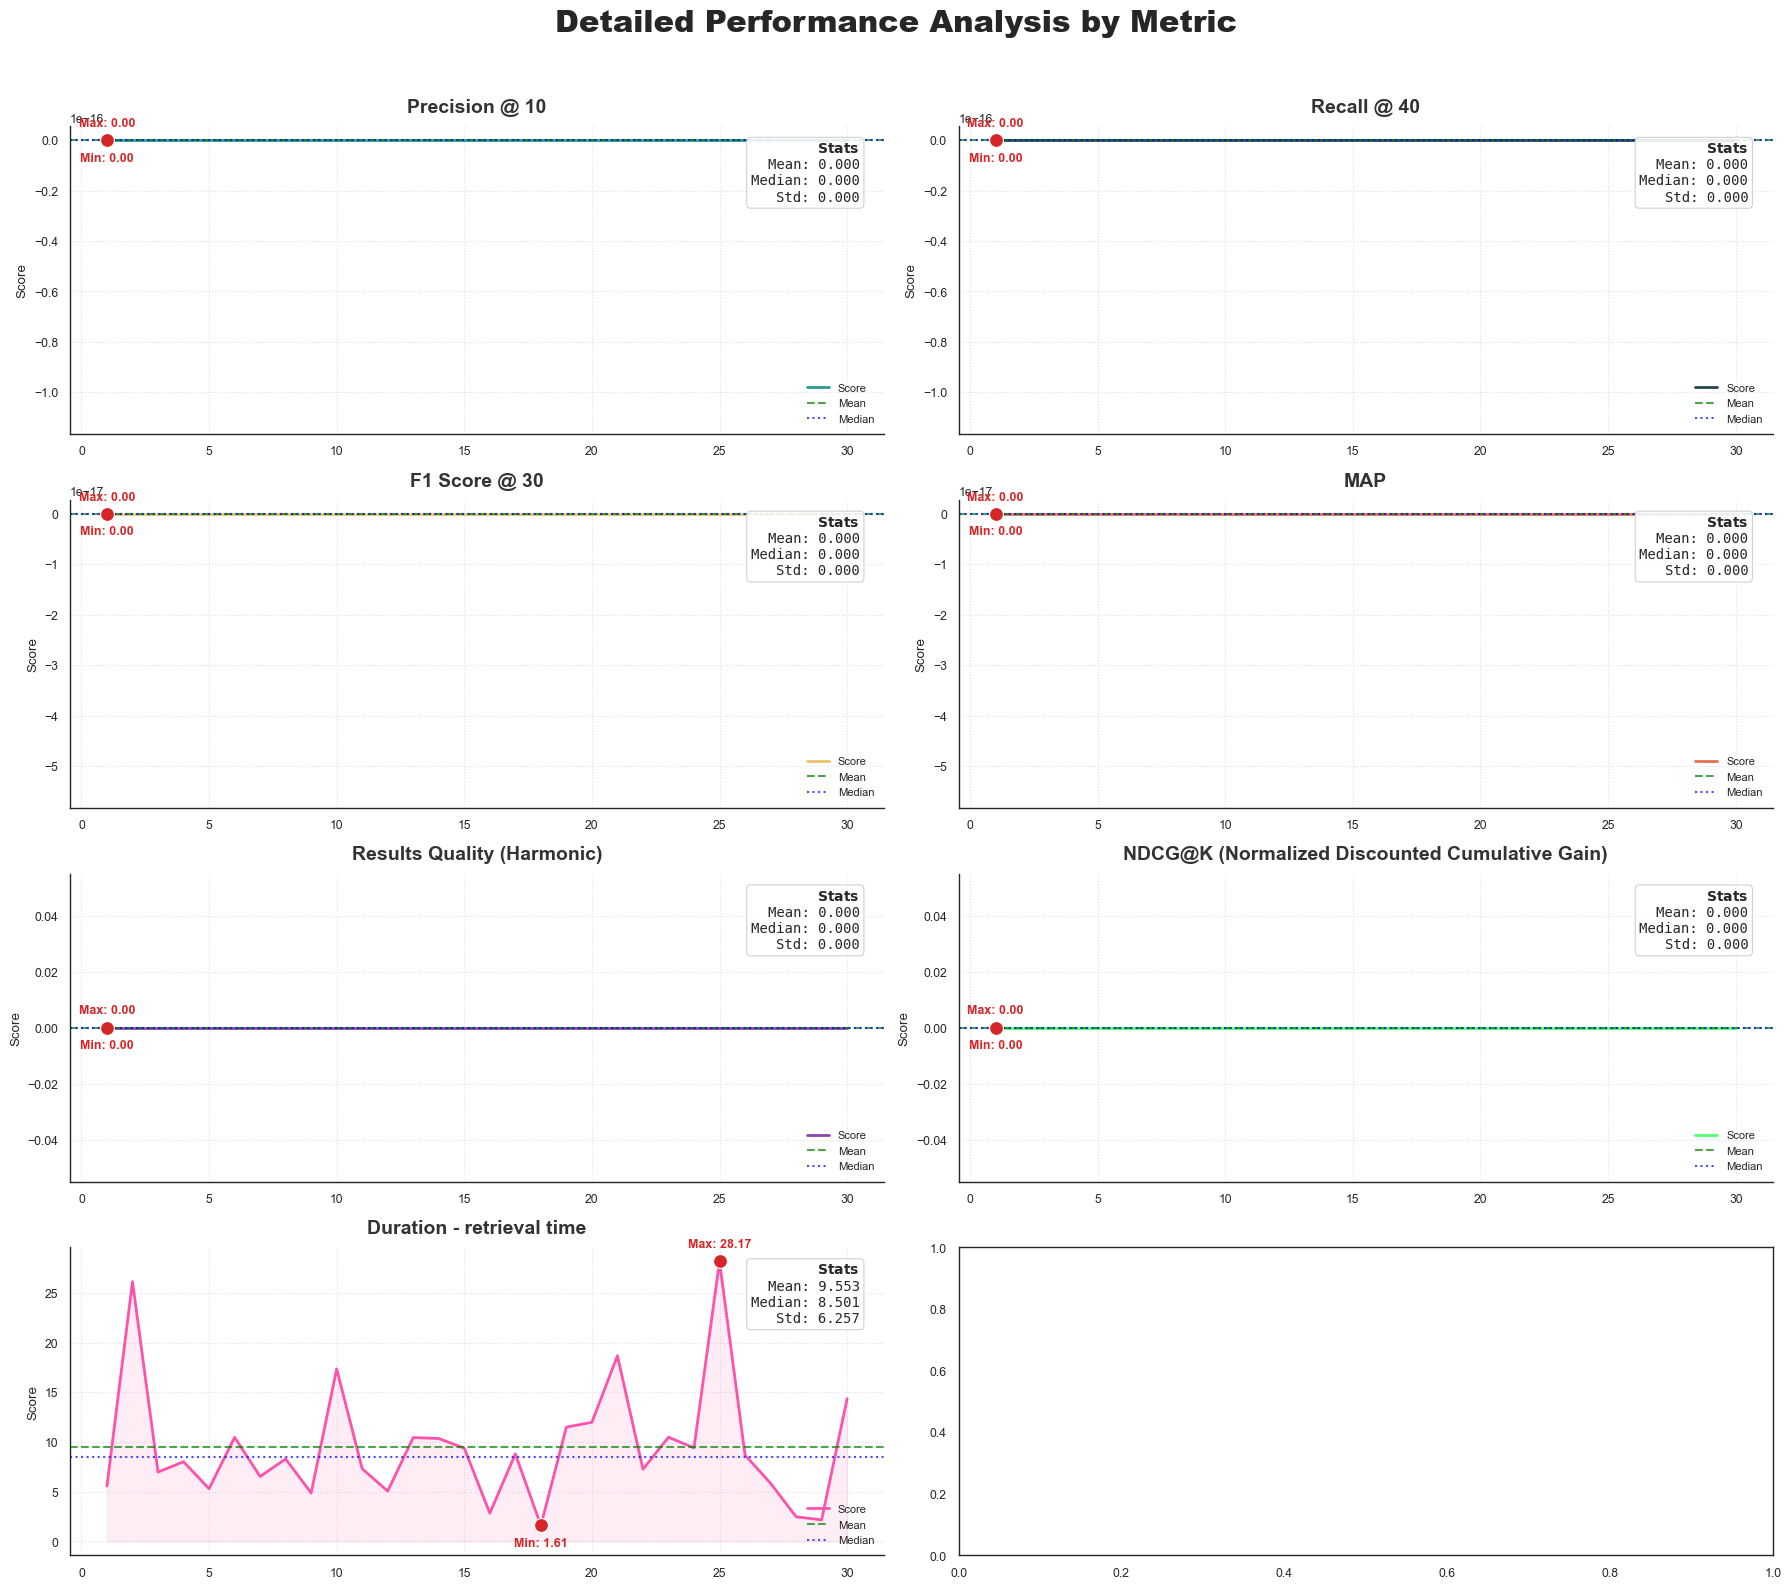

In [59]:
visulize_results(option1_res)

# Option 2

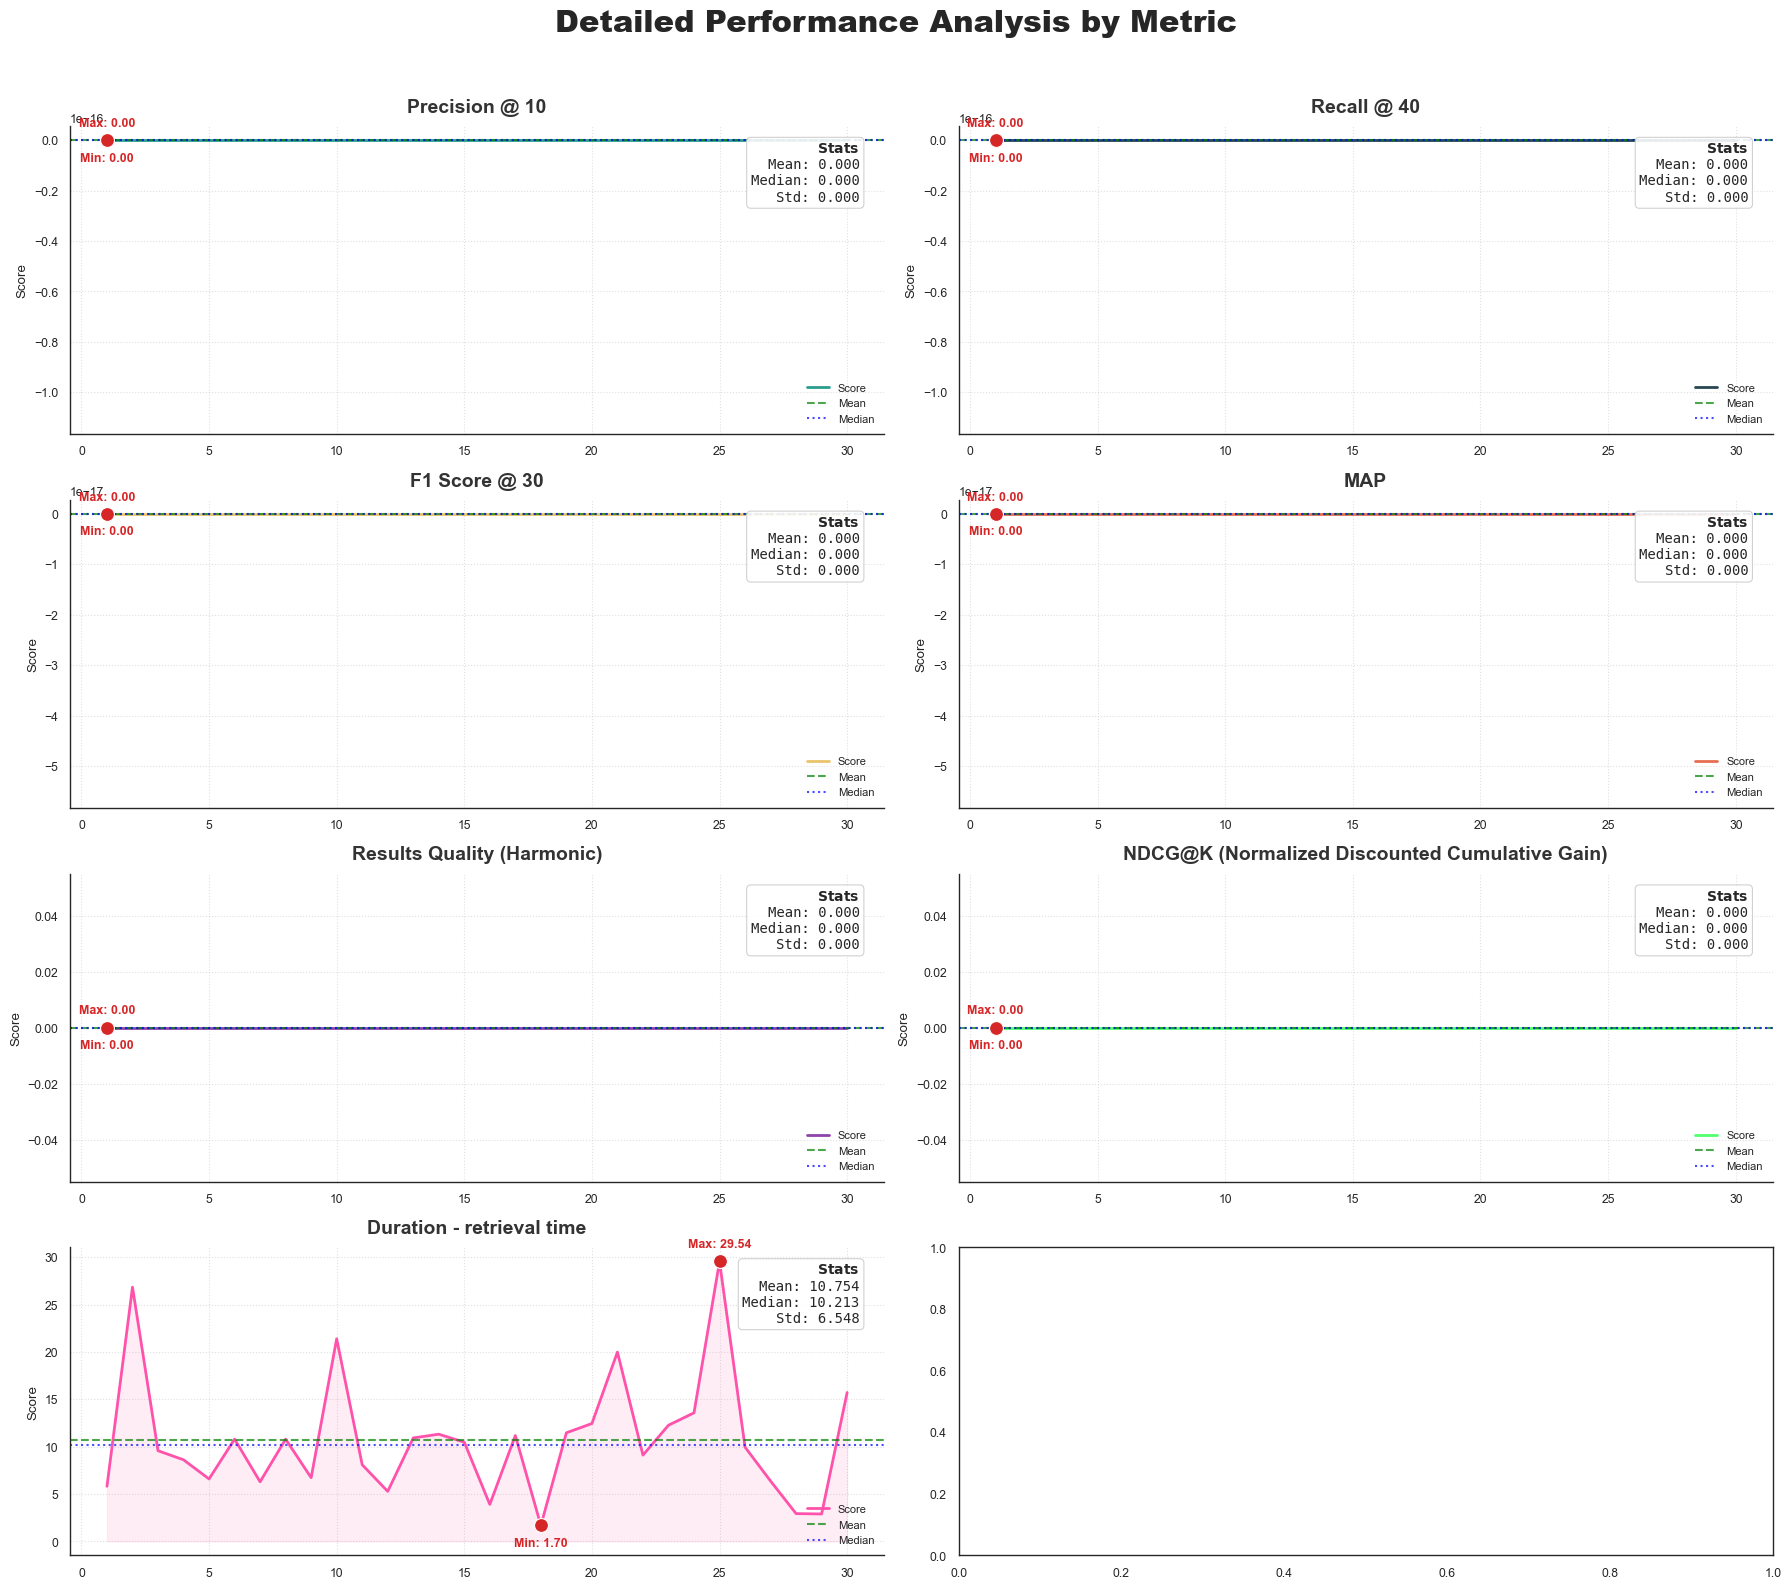

In [61]:
option2_res = get_results()
visulize_results(option2_res)

## Option3

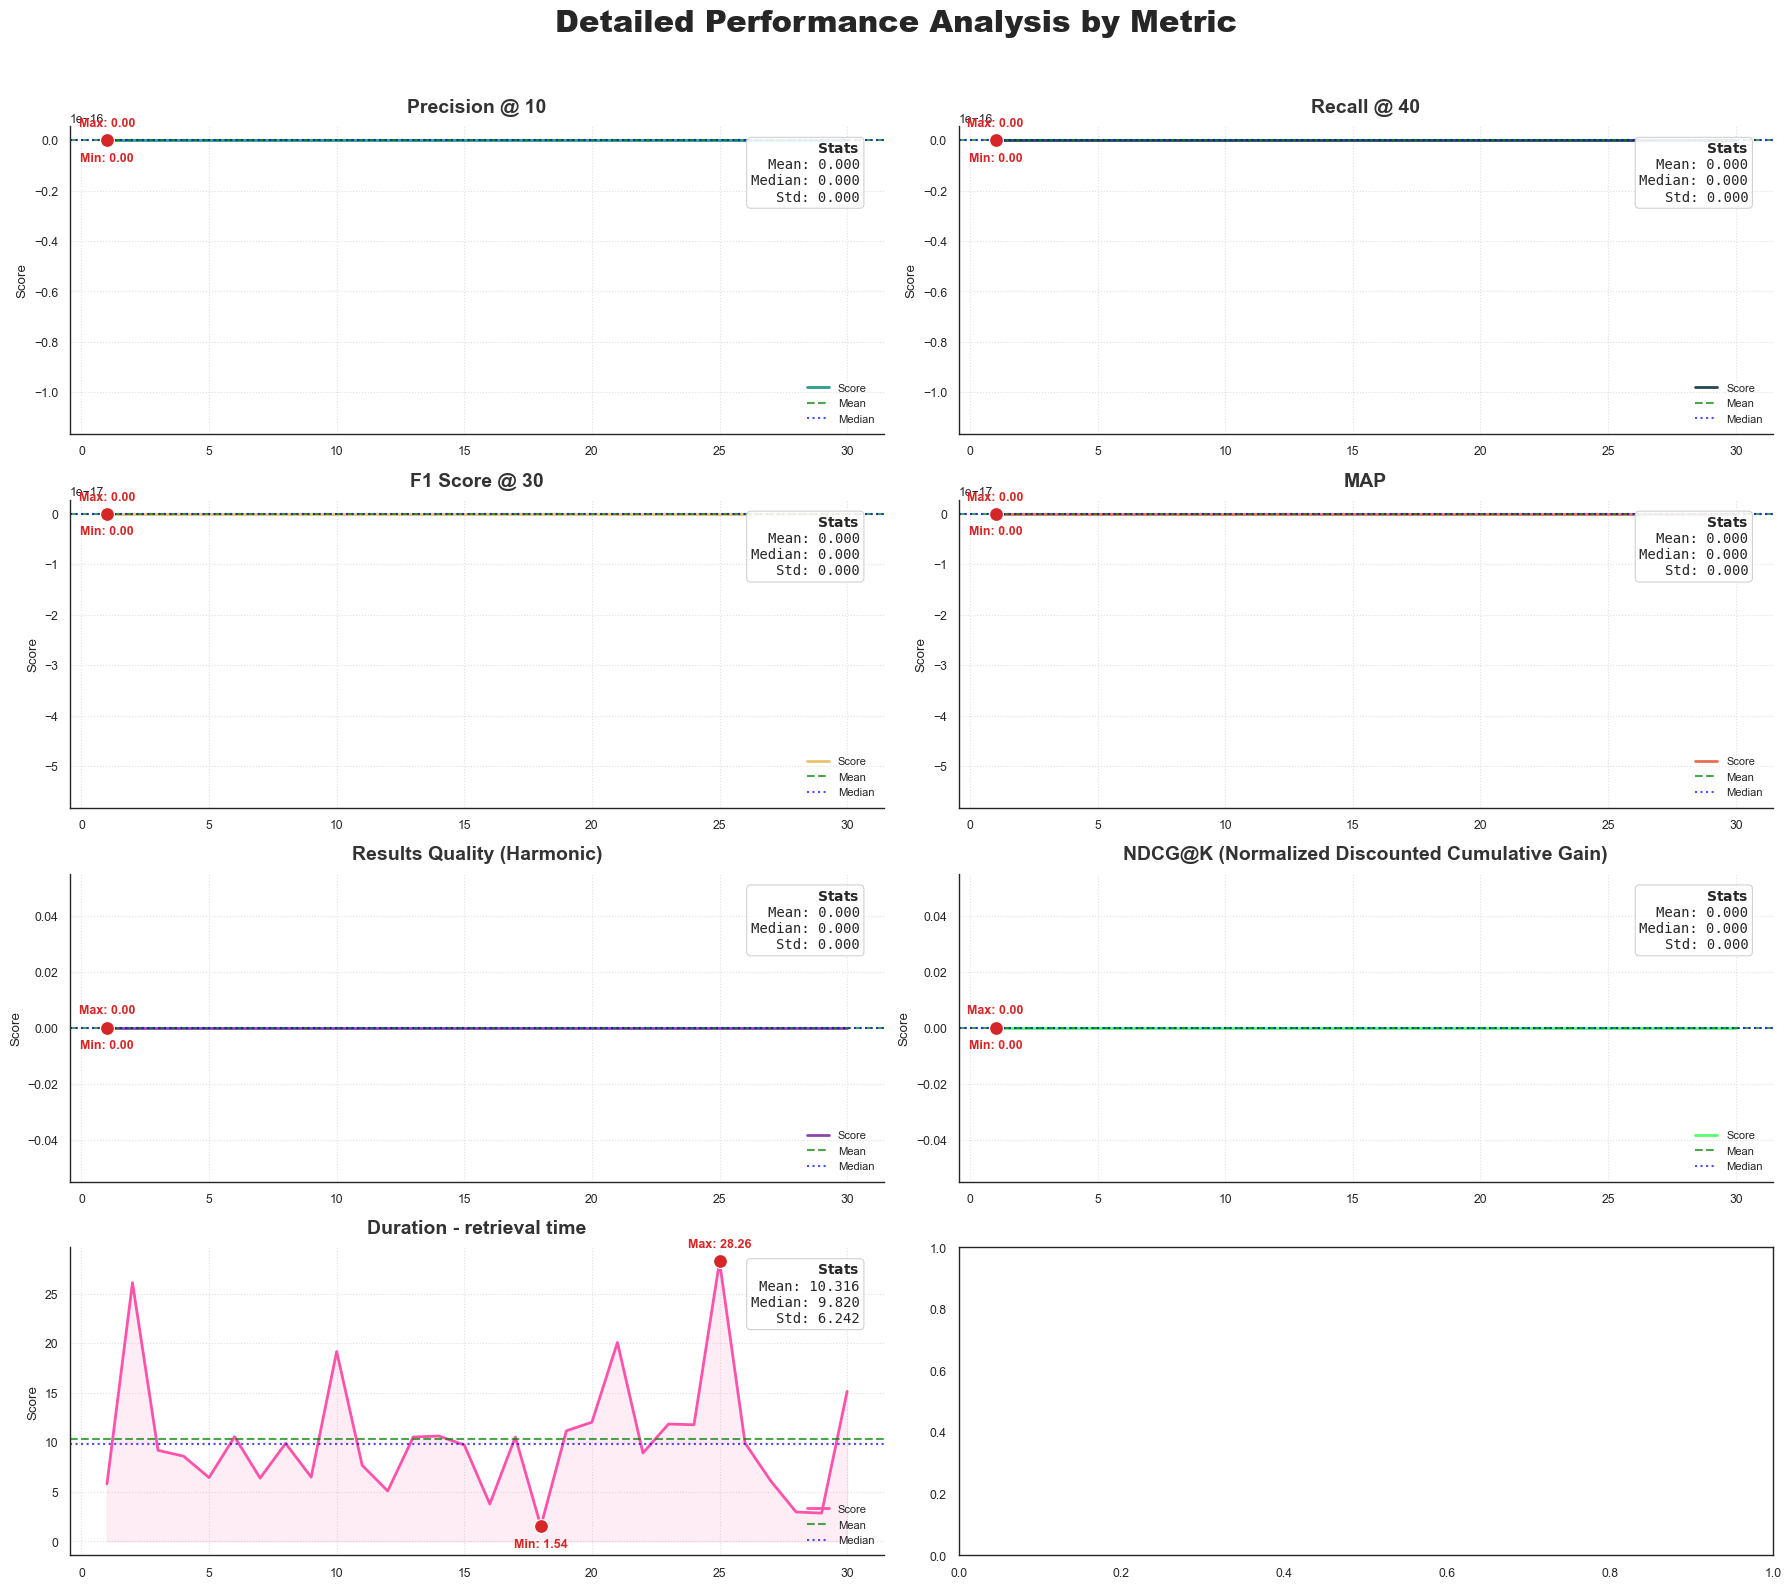

In [64]:
option3_res = get_results()
visulize_results(option3_res)

## Option4

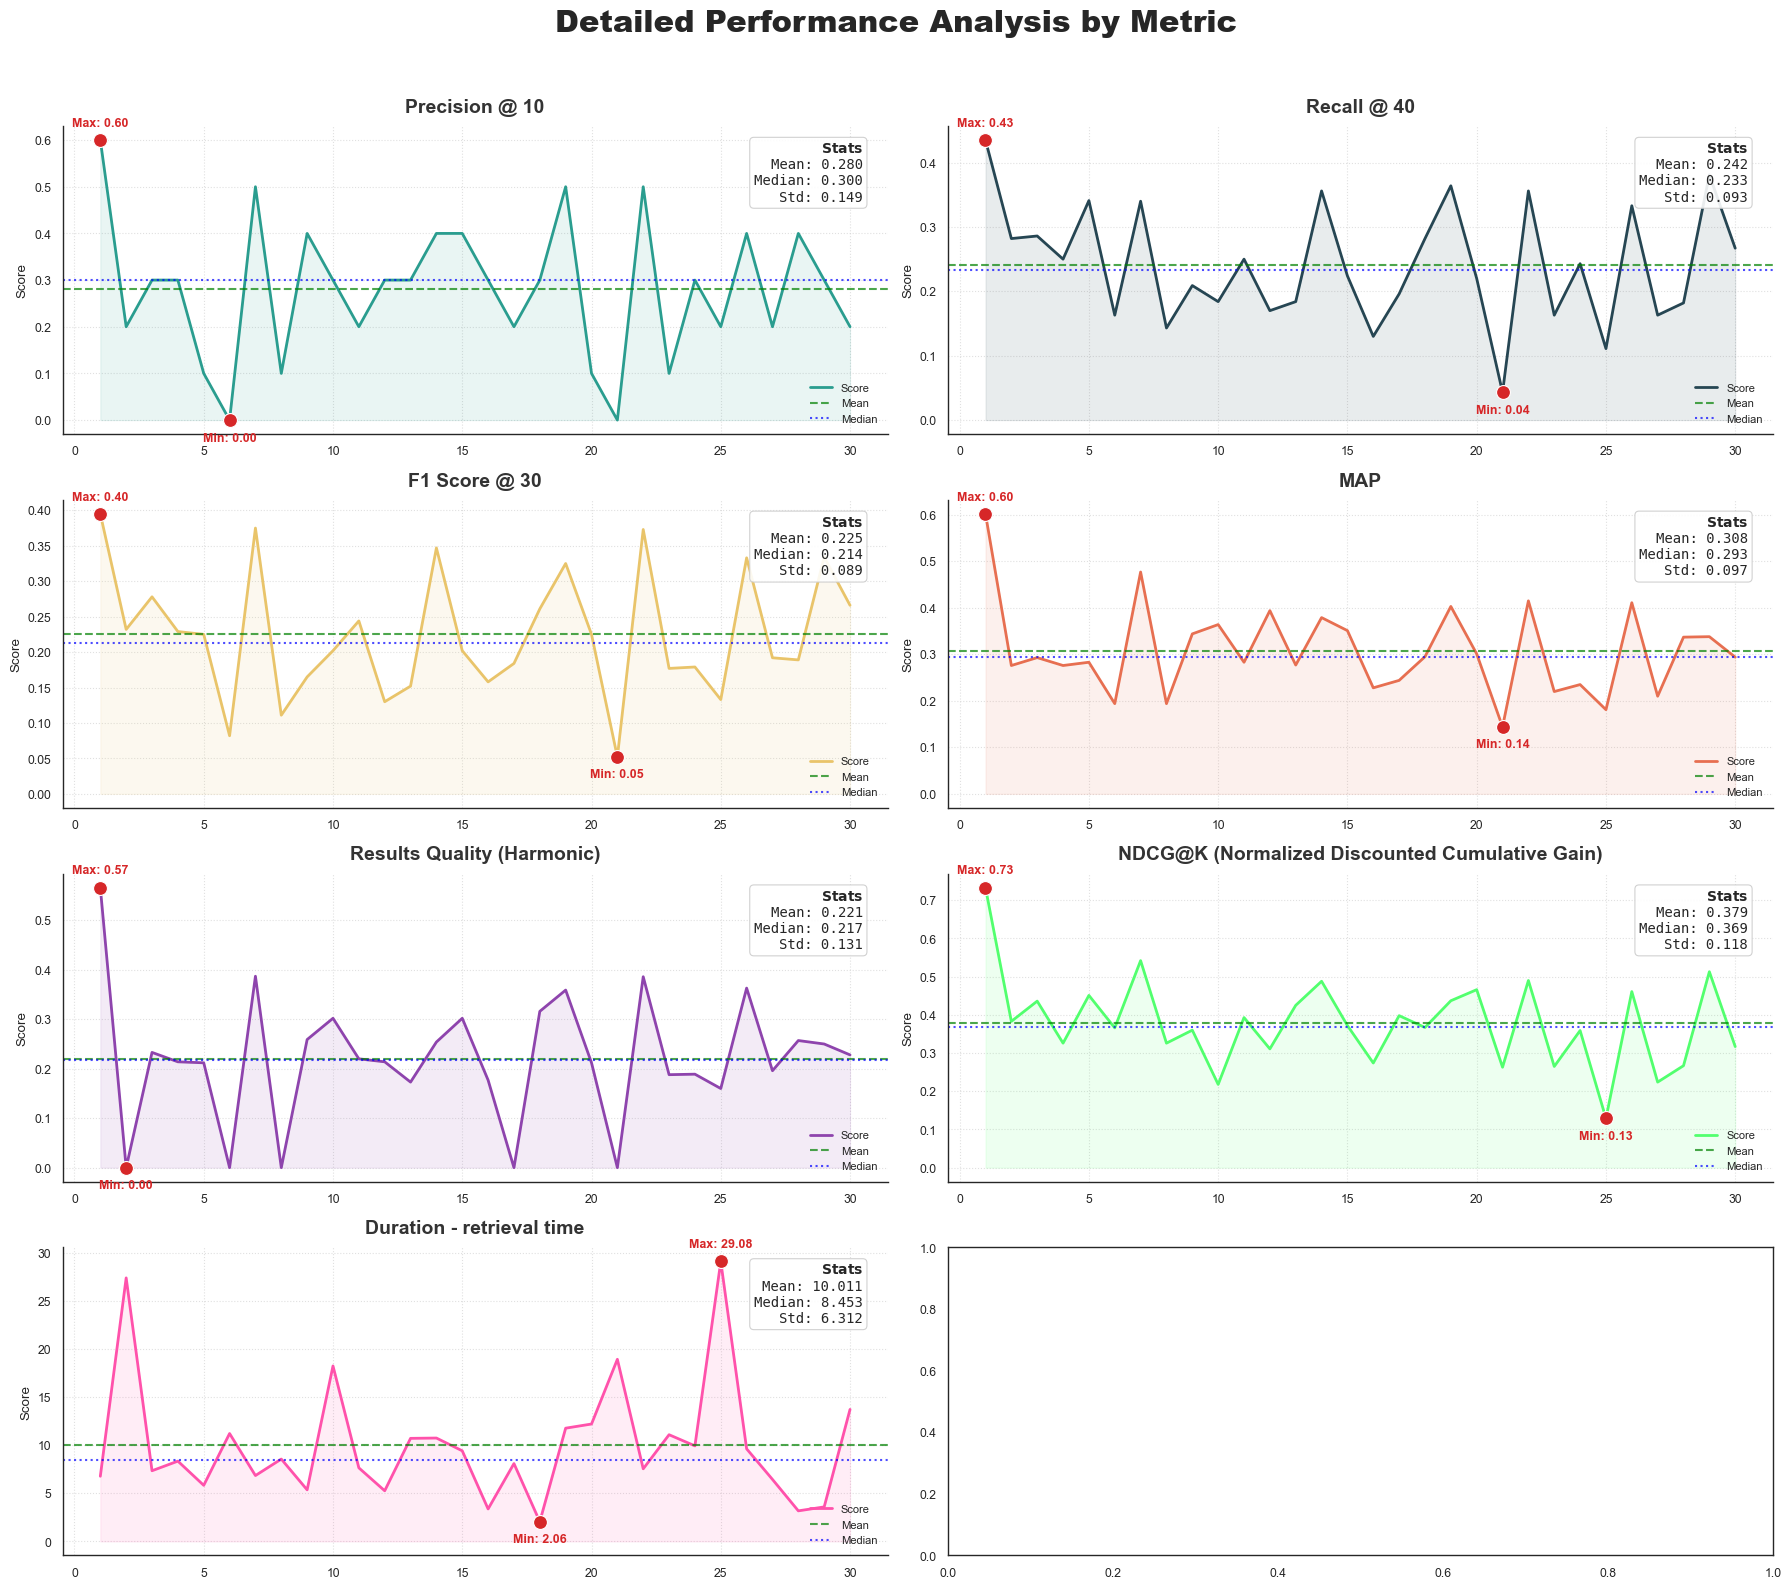

In [63]:
option4_res = get_results()
visulize_results(option4_res)

## Option5

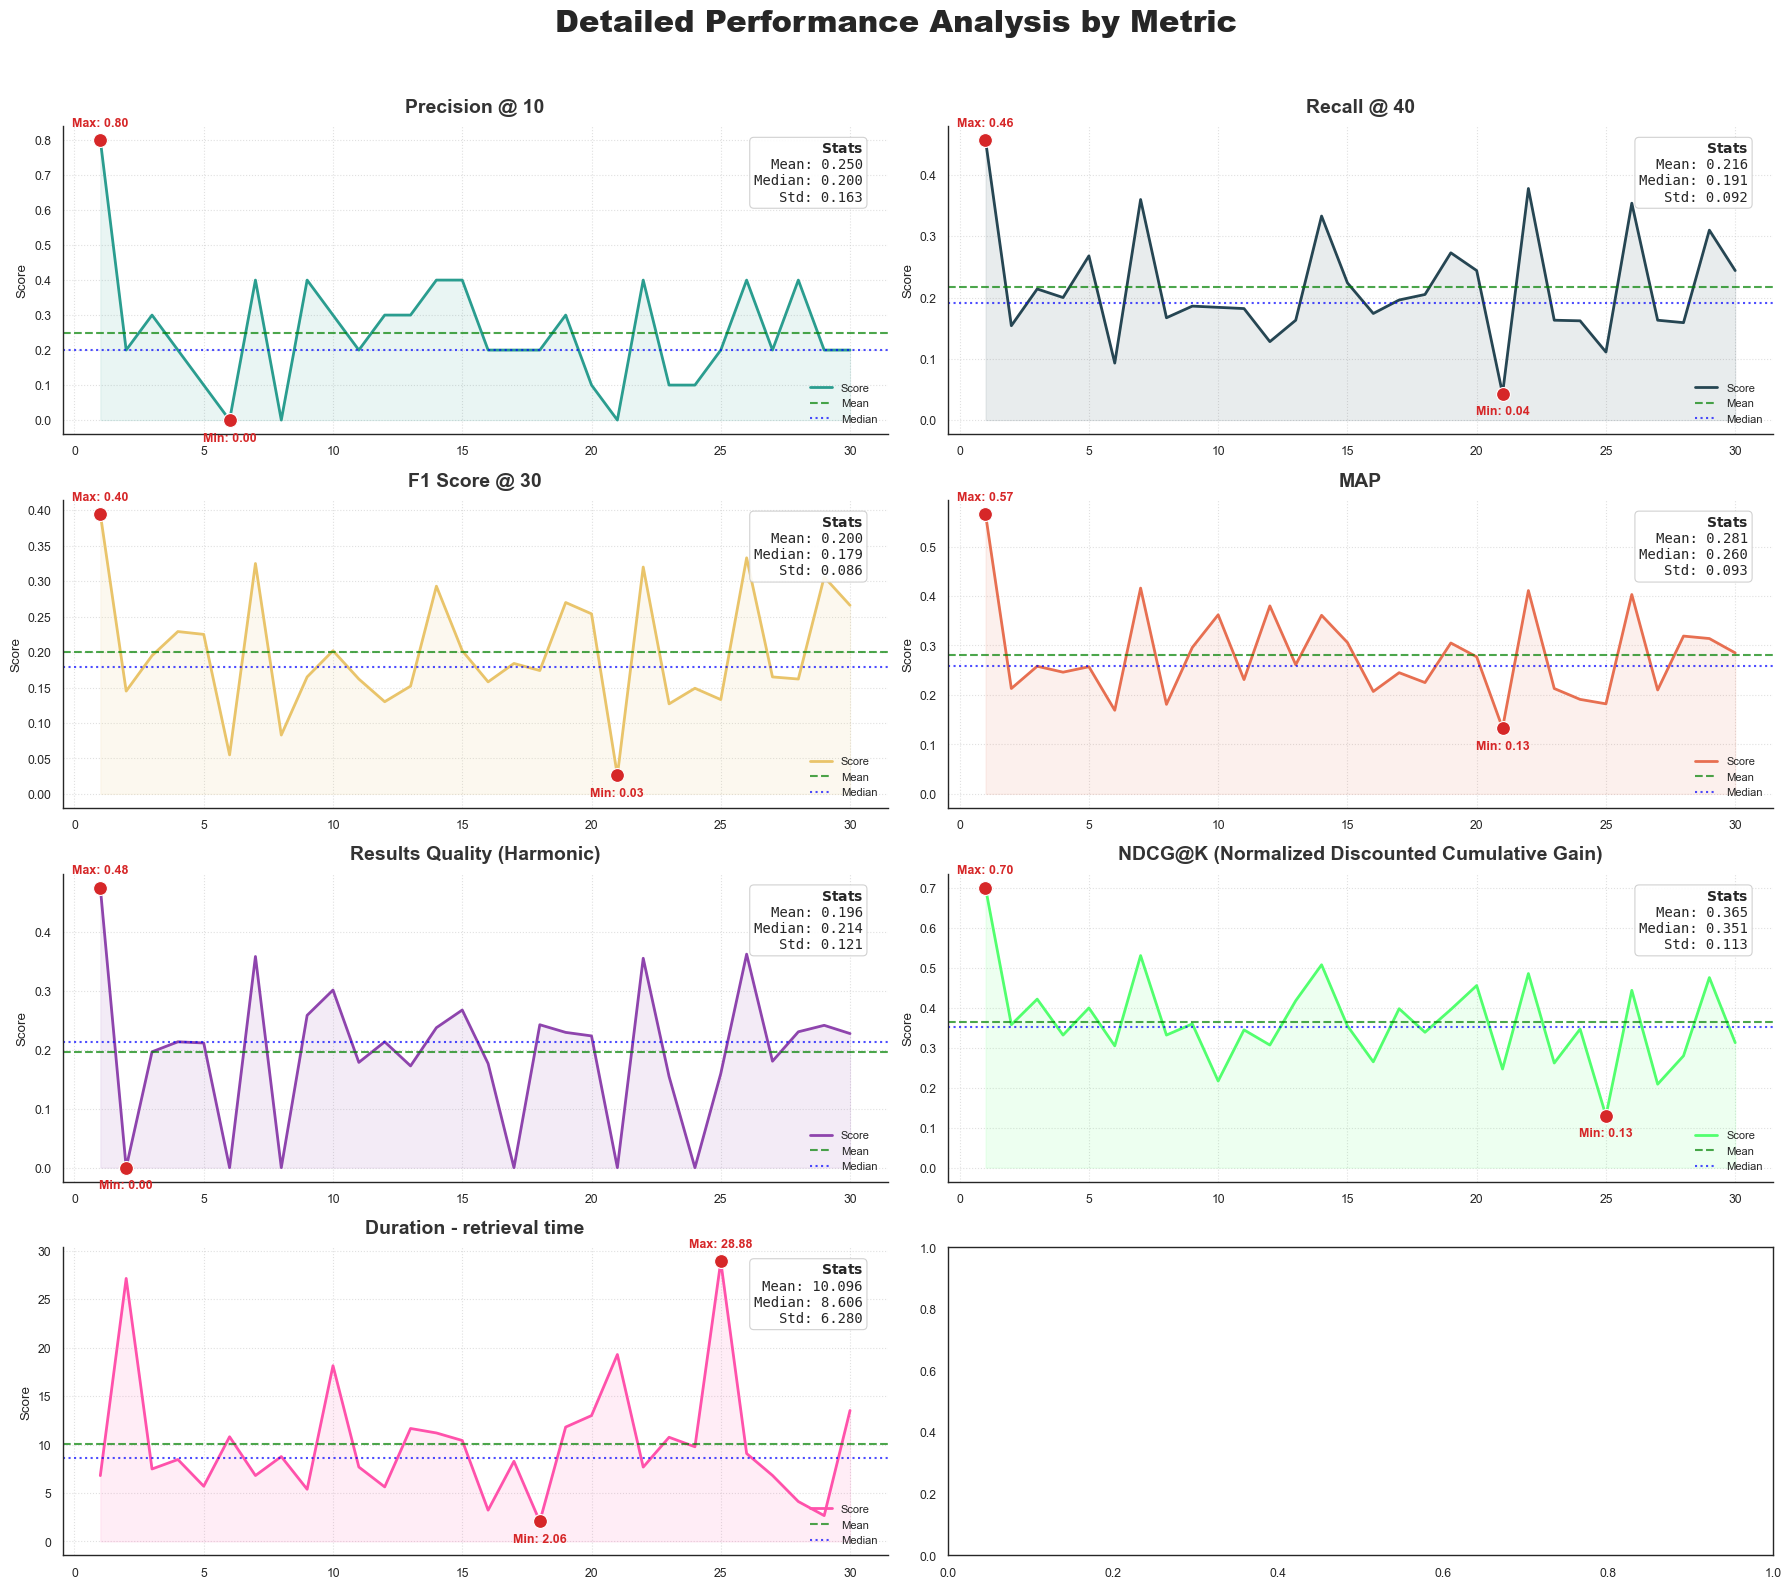

In [62]:
option5_res = get_results()
visulize_results(option5_res)

## Option6

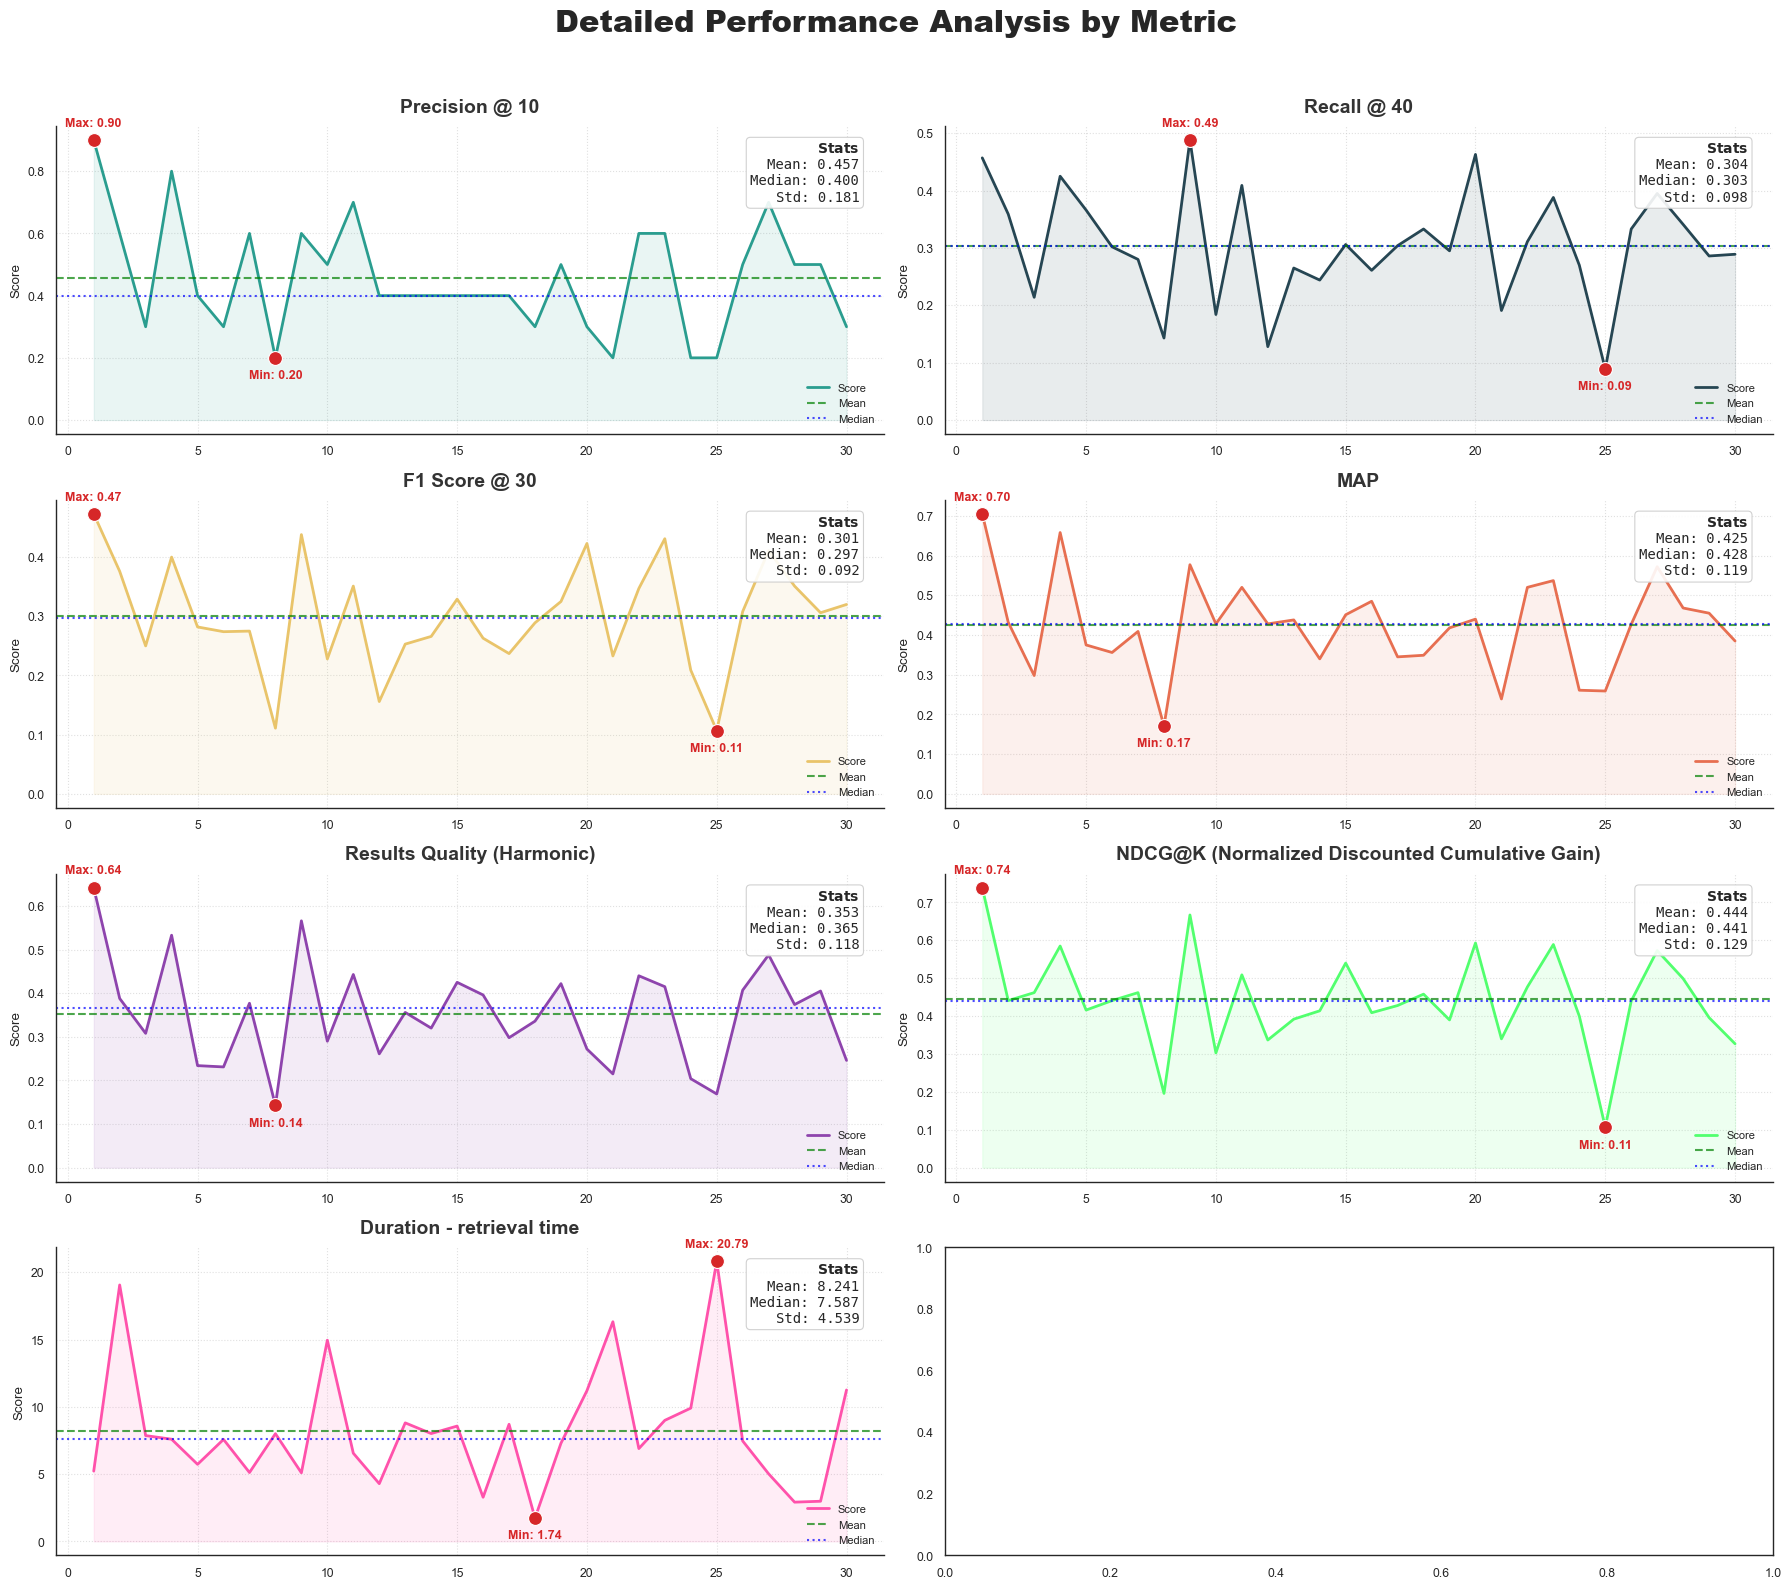

In [65]:
option6_res = get_results()
visulize_results(option6_res)

## Option7

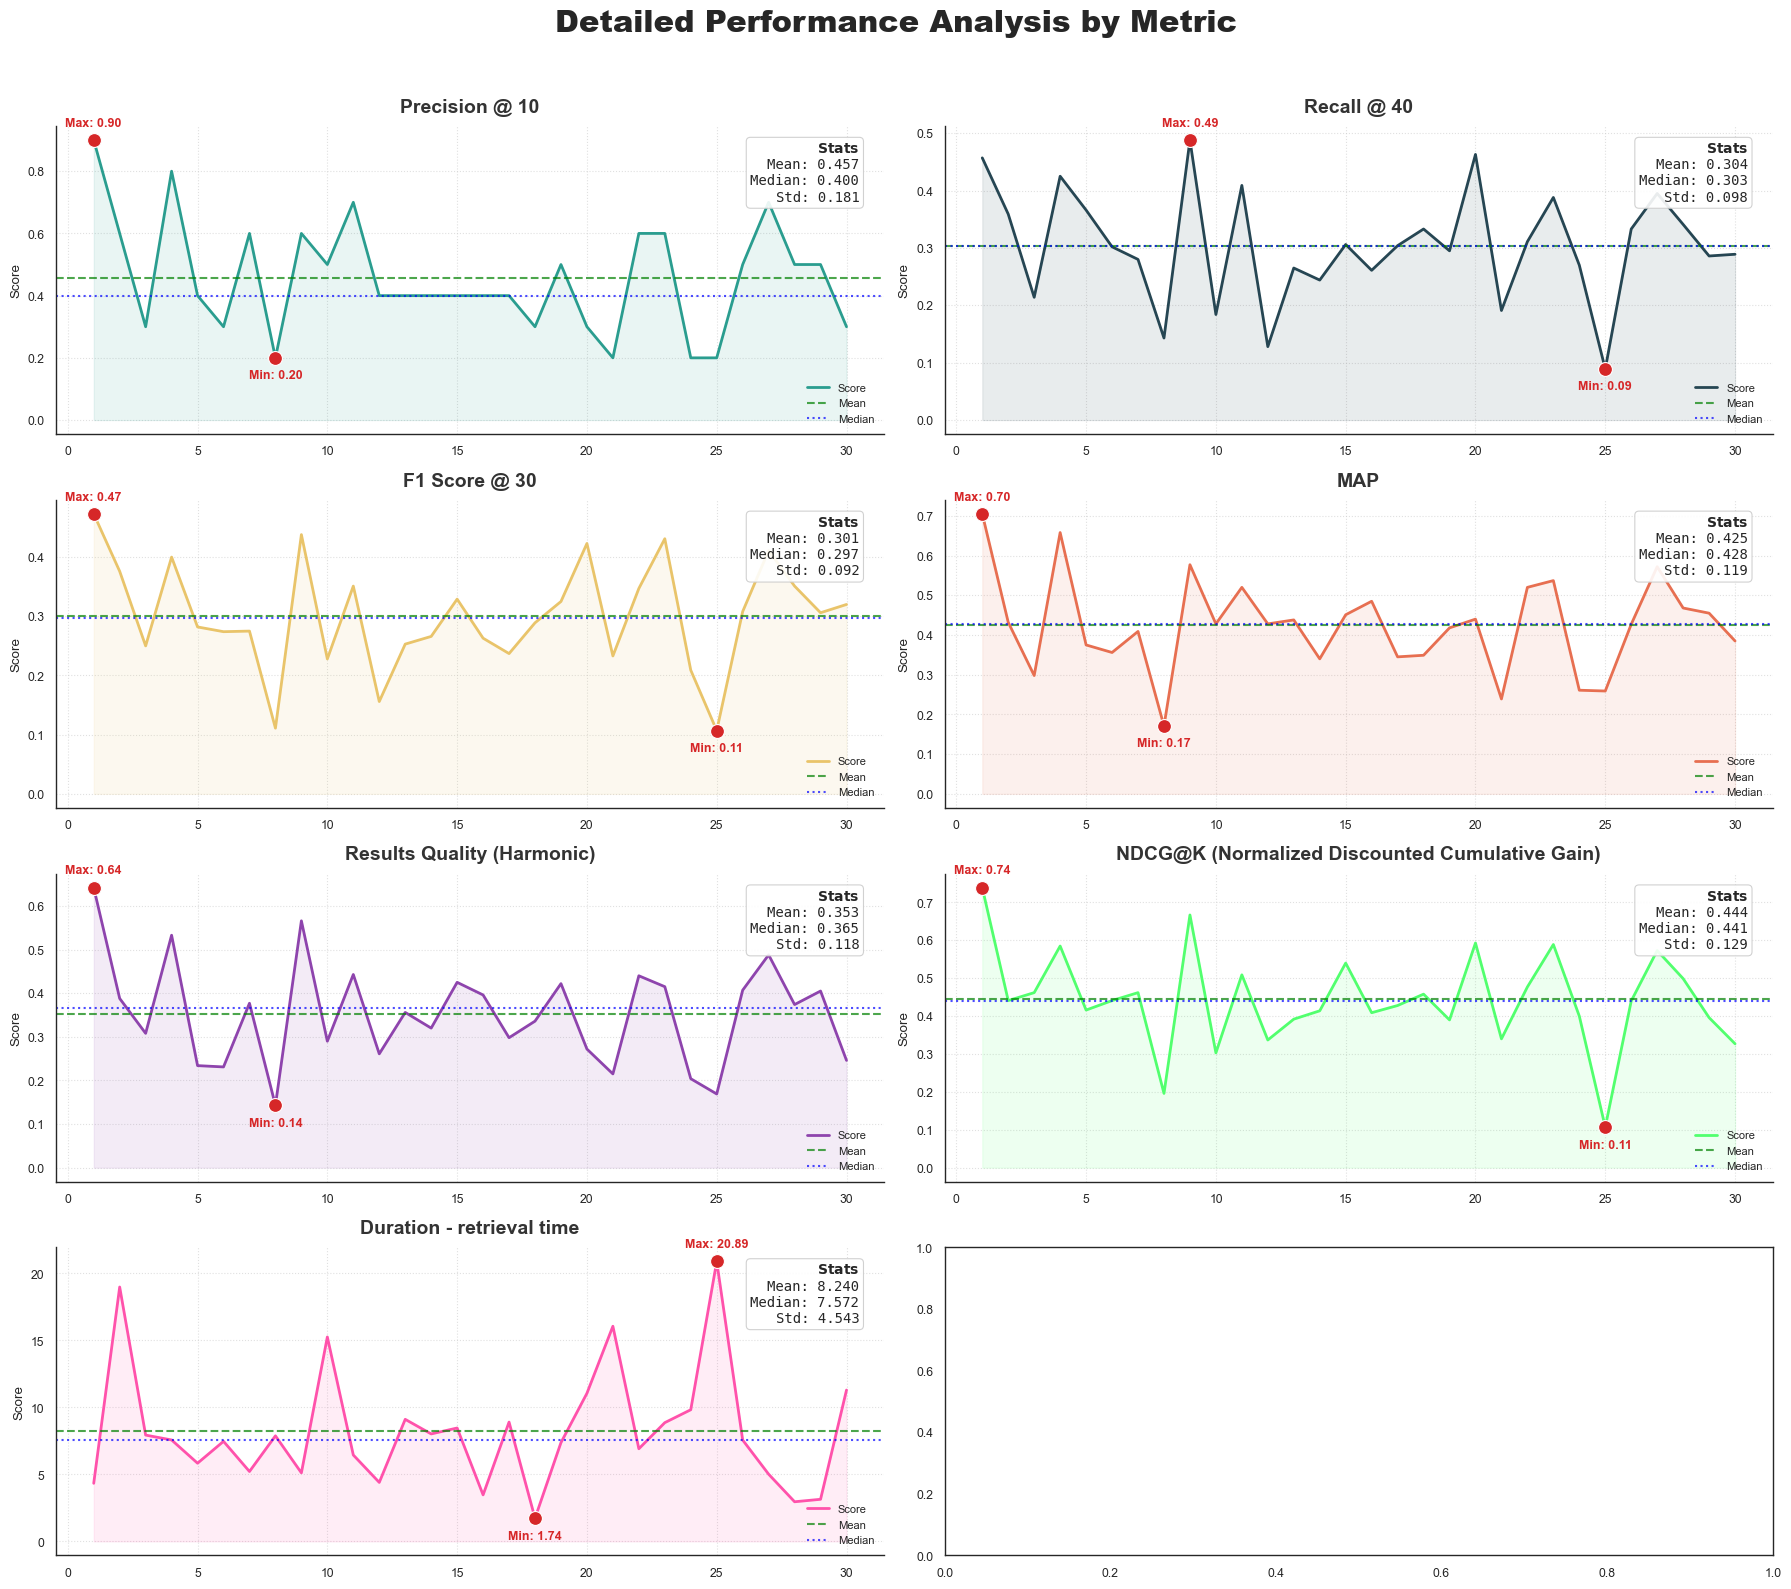

In [66]:
option7_res = get_results()
visulize_results(option7_res)

## Optio8

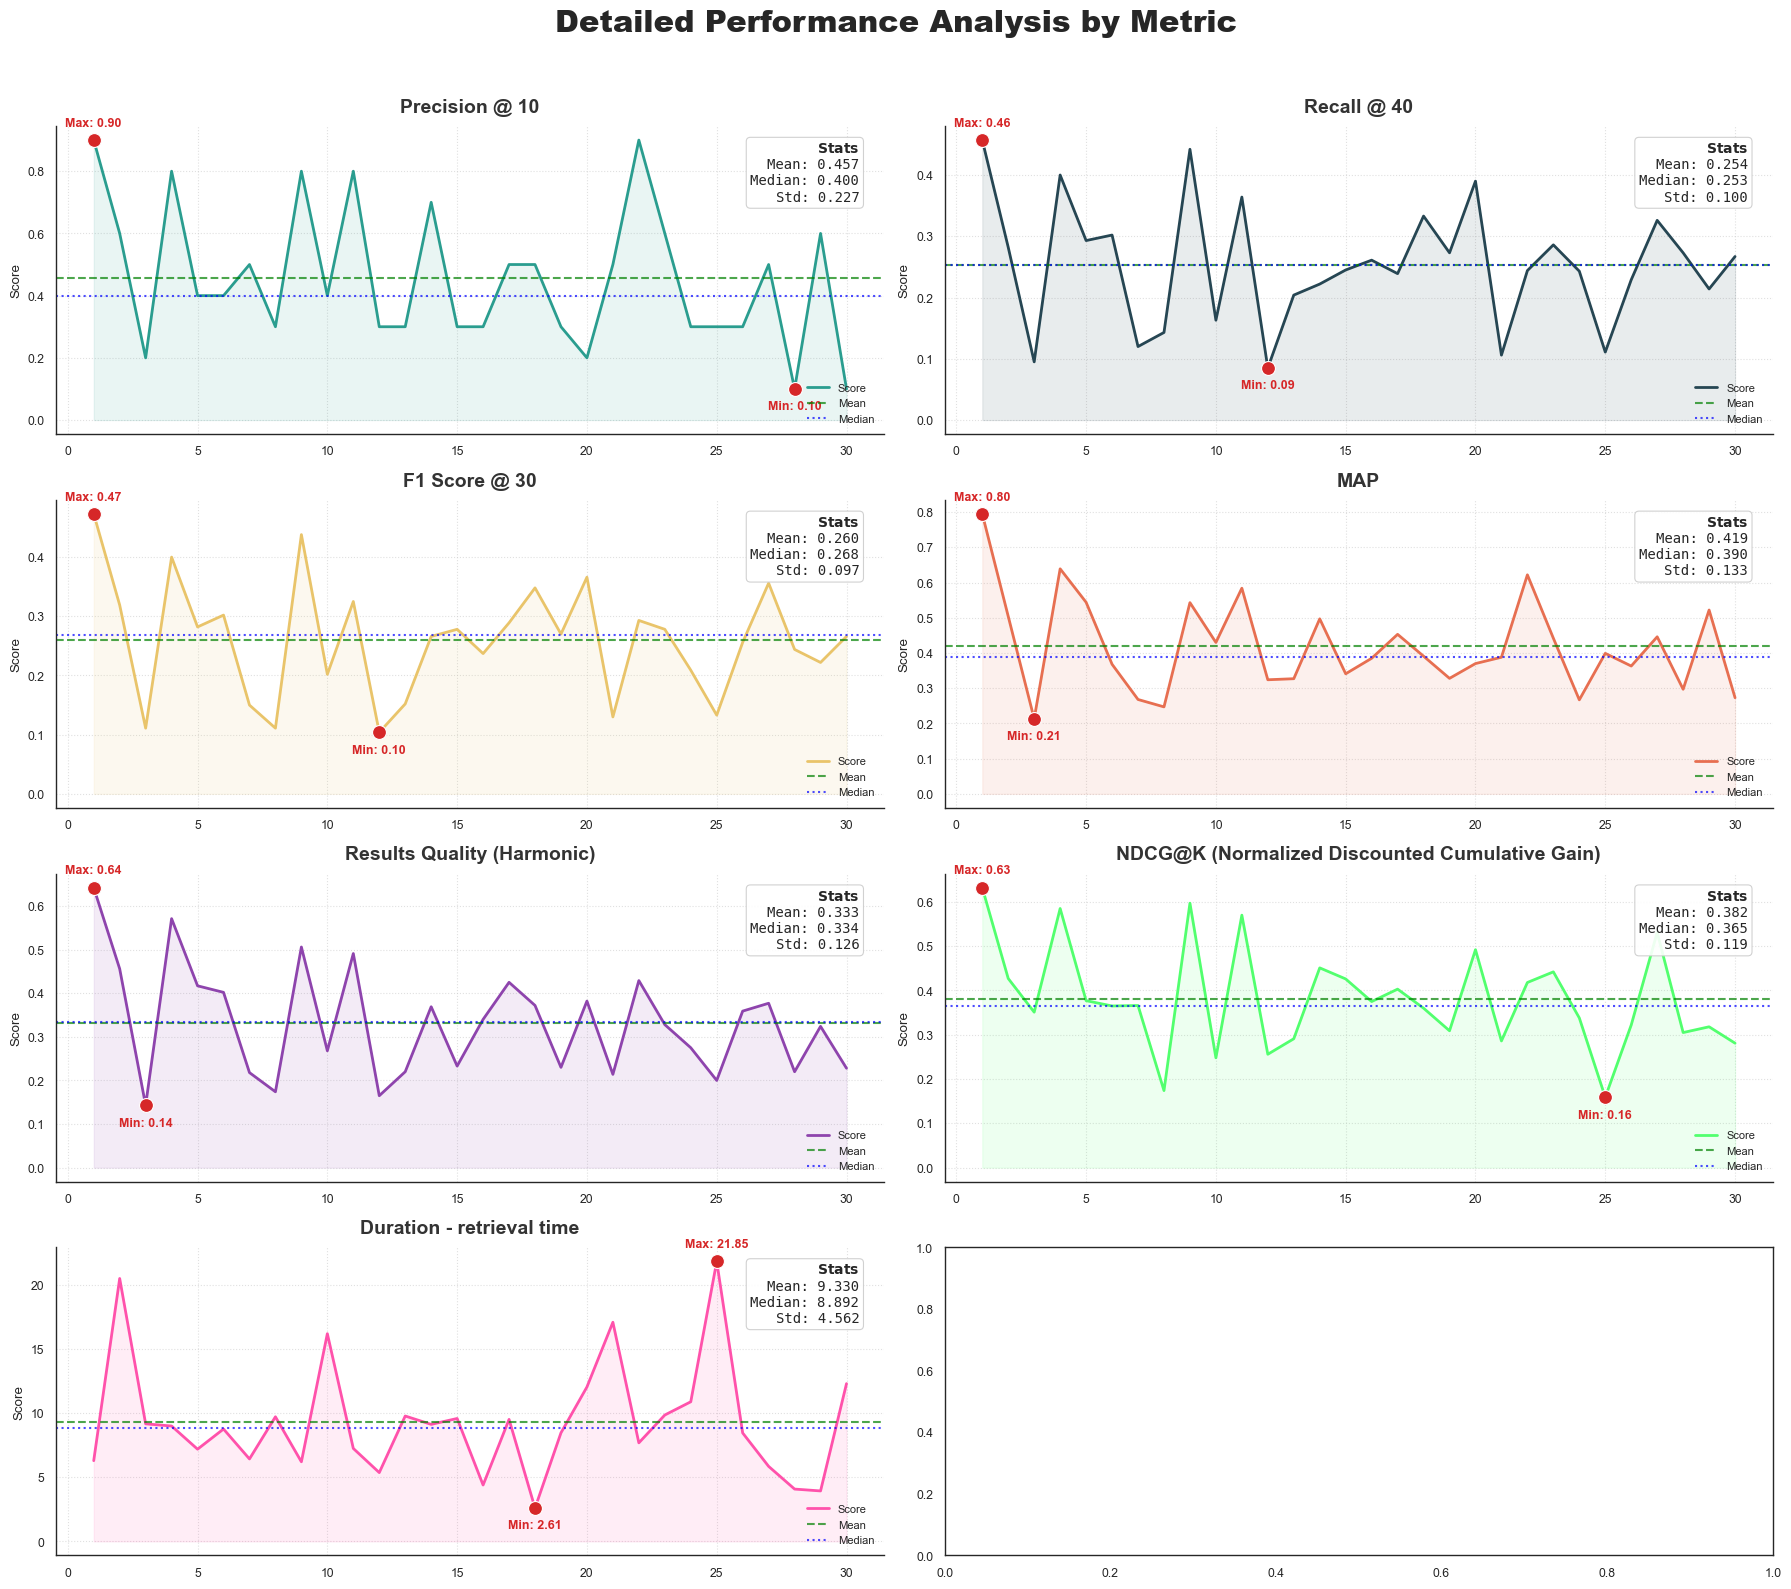

In [8]:
option8_res = get_results()
visulize_results(option8_res)

## Option9

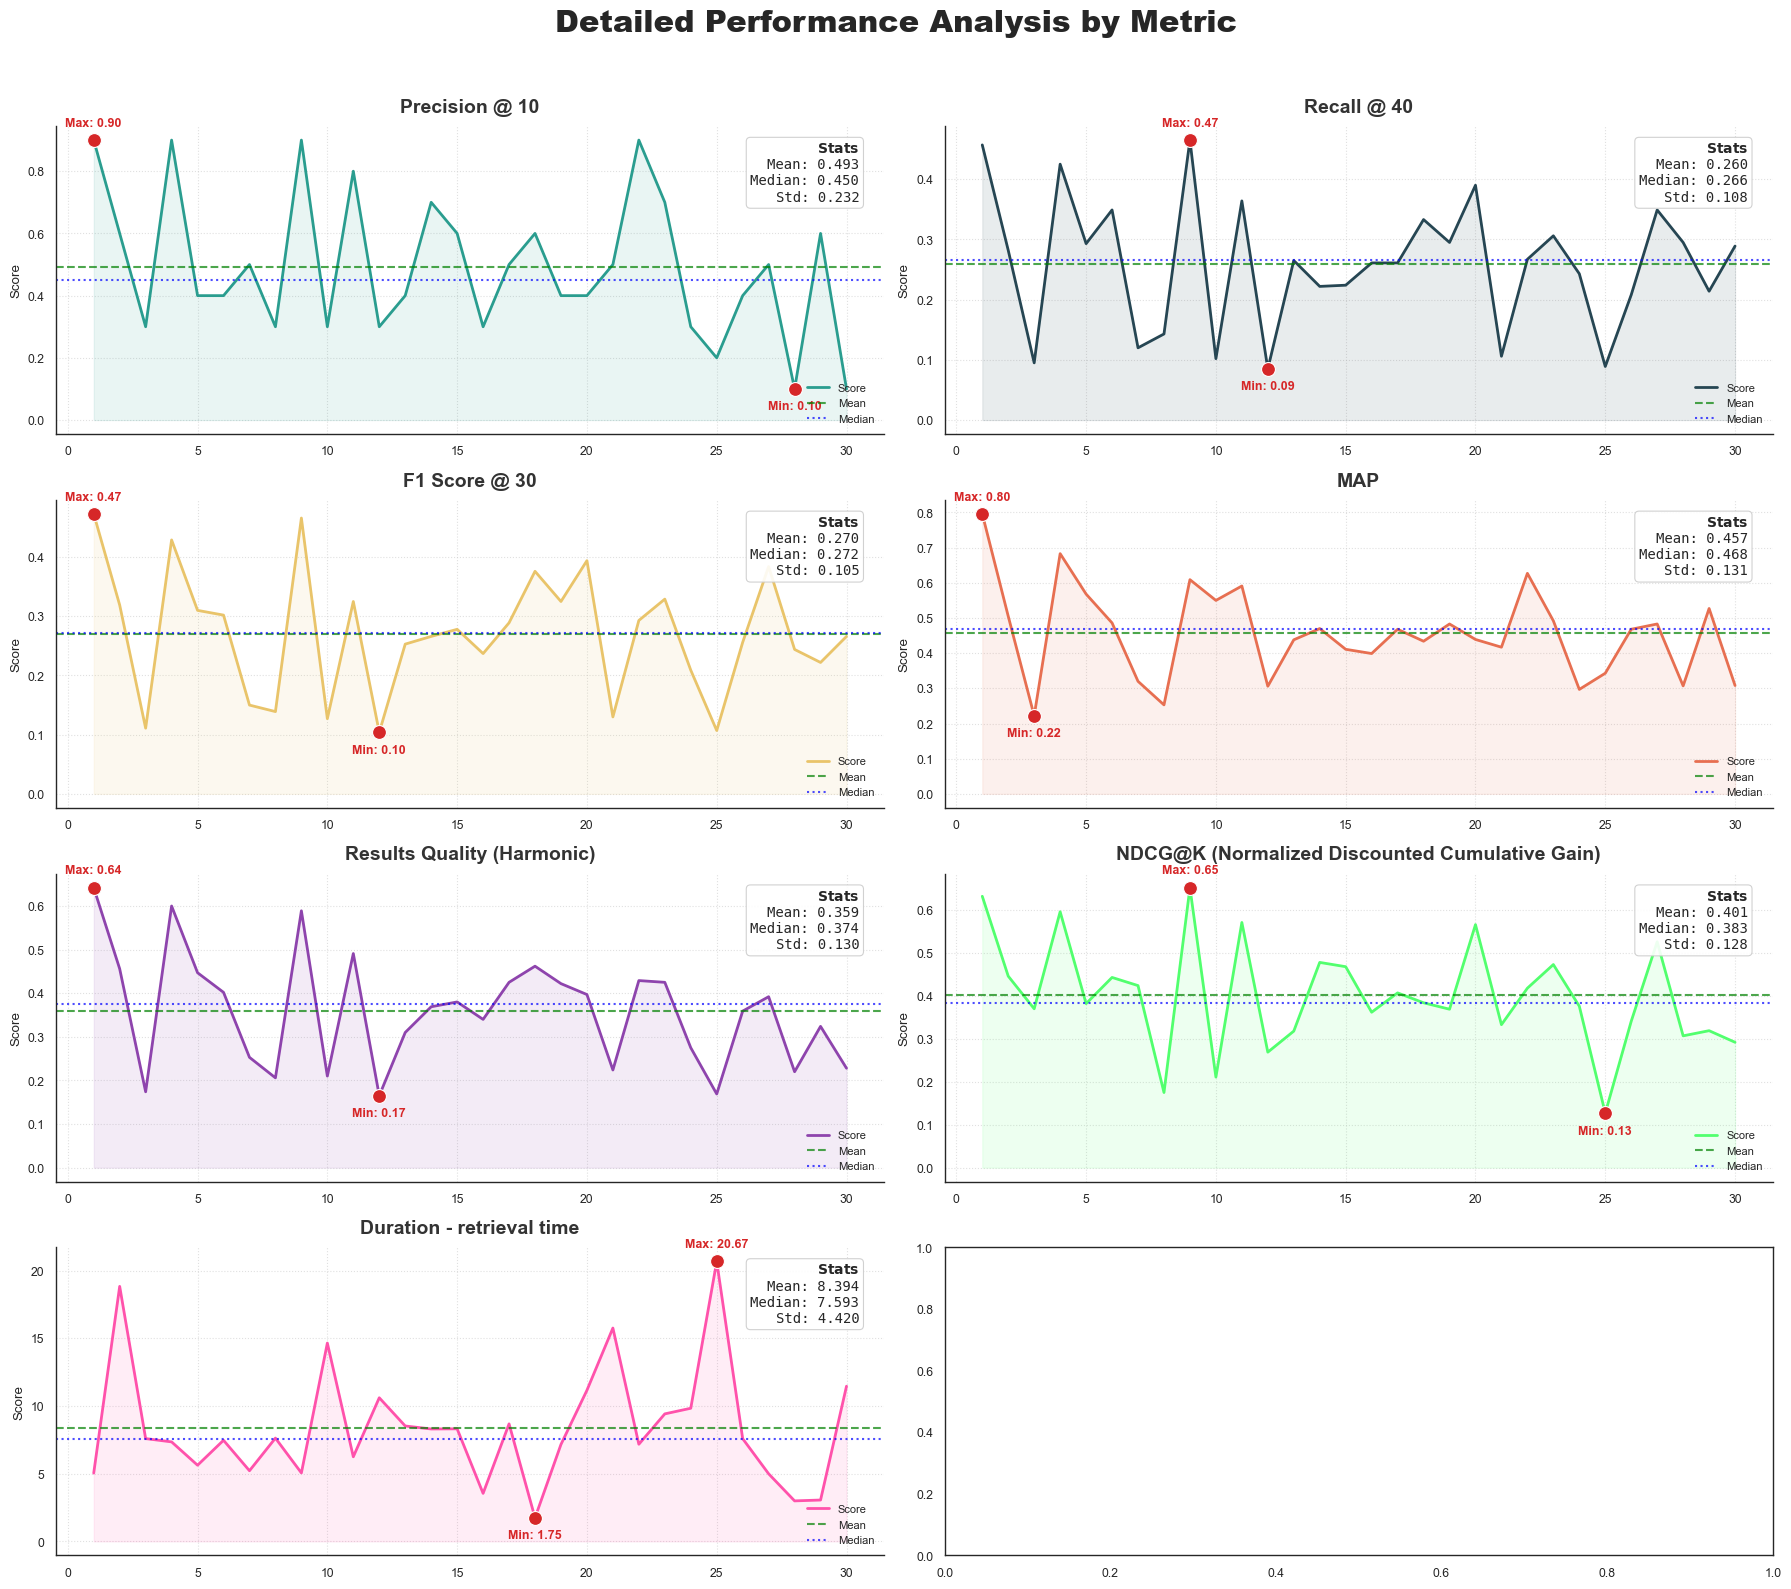

In [9]:
option10_res = get_results()
visulize_results(option10_res)

In [2]:
import pickle
import os
results = []
files = sorted(list(os.listdir("results/")), key=lambda value: int(value.split("_")[1].split(".")[0]))
for filename in files:
    print(filename)
    with open(f"results/{filename}", "rb") as f:
        results.append(pickle.load(f))


results_1.pkl
results_2.pkl
results_3.pkl
results_4.pkl
results_5.pkl
results_6.pkl
results_7.pkl
results_8.pkl
results_10.pkl


In [ ]:
import requests

# isolate the evaluation data
results_option10 = results[-1]
# extract specific metric for comparison
rq_scores = [element[2] for element in results_option10]
# find the indices of the queries with the lowest and highest quality scores
min_val_index = np.argmin(rq_scores)
max_val_index = np.argmax(rq_scores)

# element[0] is the query text itself
worst_query = results_option10[min_val_index][0]
best_query = results_option10[max_val_index][0]

# Re-run the search for these specific queries to see the actual document IDs and scores
url = 'http://35.239.201.94:8080'
# Fetch results for the worst performing query to analyze why it failed
worst_res = requests.get(url + '/search', {'query': worst_query}, timeout=35)
# Fetch results for the best performing query to see what it did right
best_res = requests.get(url + '/search', {'query': best_query}, timeout=35)

# Convert responses to JSON
worst_res_json = worst_res.json()
best_res_json = best_res.json()

In [ ]:
df = pd.read_parquet("titles_df", engine='pyarrow')
title_df = df.set_index("id")["title"]

In [47]:
gt_results = [title_df.get(int(doc_id)) for doc_id in queries[worst_query][:10]]
top_10_in_worst_query = [element[1] for element in worst_res_json[:10]]
def results_to_str(res_lst):
    return '\n'.join([f"{i+1}.{val}" for i, val in enumerate(res_lst)])
print(f"worst_query: {worst_query} with score: {np.min(rq_scores)}")
print("----------")
print(f"gt top10 results: \n{results_to_str(gt_results)}")
print("-------------------------")
print(f"our engine top10 results: \n{results_to_str(top_10_in_worst_query)}")

worst_query: Steam locomotive transportation history with score: 0.165
----------
gt top10 results: 
1.Steam locomotive
2.Steam engine
3.History of rail transport
4.History of the steam engine
5.Locomotive
6.2-8-2
7.History of steam road vehicles
8.Rail transport
9.2-6-0
10.History of rail transportation in the United States
-------------------------
our engine top10 results: 
1.Rail transport
2.Steam locomotive
3.Steam locomotive components
4.5AT Advanced Technology Steam Locomotive
5.Steam locomotives of Ireland
6.Geared steam locomotive
7.Steam locomotives of British Railways
8.List of preserved steam locomotives in Germany
9.Condensing steam locomotive
10.Steam locomotives of the 21st century


In [48]:

top_10_in_best_query = [element[1] for element in best_res_json[:10]]
gt_results = [title_df.get(int(doc_id)) for doc_id in queries[best_query][:10]]

print(f"best_query: {best_query} with score: {np.max(rq_scores)}")
print("----------")
print(f"gt top10 results: \n{results_to_str(gt_results)}")
print("-------------------------")
print(f"our engine top10 results: \n{results_to_str(top_10_in_best_query)}")

best_query: Mount Everest climbing expeditions with score: 0.642
----------
gt top10 results: 
1.List of Mount Everest expeditions
2.Timeline of Mount Everest expeditions
3.1922 British Mount Everest expedition
4.1953 British Mount Everest expedition
5.Mount Everest
6.1996 Mount Everest disaster
7.1924 British Mount Everest expedition
8.List of Mount Everest records
9.List of people who died climbing Mount Everest
10.1960 Chinese Mount Everest expedition
-------------------------
our engine top10 results: 
1.Mount Everest
2.Timeline of Mount Everest expeditions
3.1924 British Mount Everest expedition
4.1922 British Mount Everest expedition
5.1933 British Mount Everest expedition
6.1975 British Mount Everest Southwest Face expedition
7.List of Mount Everest expeditions
8.1953 British Mount Everest expedition
9.1935 British Mount Everest reconnaissance expedition
10.2006 Philippine Mount Everest expedition


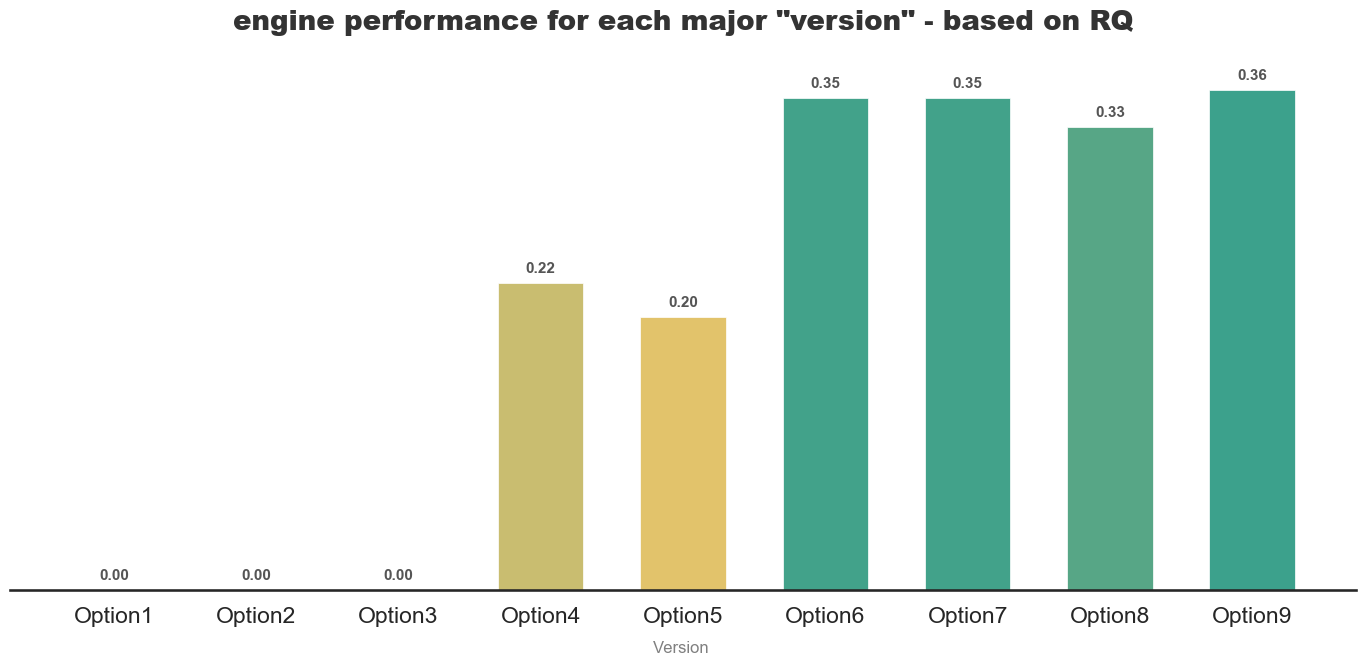

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

def plot_quality_scores_modern(scores_list):
    """
    Generates a high-end visualization for a list of performance scores.
    """
    # data preparation
    x_labels = [f'Option{i+1}' for i in range(len(scores_list))]
    df = pd.DataFrame({'Query': x_labels, 'Score': scores_list})
    
    sns.set_theme(style="white", context="talk")
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Define a custom color gradient: Red (Poor) -> Yellow (Mid) -> Teal (Excellent)
    cmap = LinearSegmentedColormap.from_list("custom_quality", ["#e76f51", "#e9c46a", "#2a9d8f"])
    
    # Normalize color mapping based on the score range
    norm = plt.Normalize(min(scores_list) * 0.9, max(scores_list) * 1.05)
    colors = [cmap(norm(value)) for value in scores_list]

    bars = ax.bar(df['Query'], df['Score'], color=colors, width=0.6, edgecolor='white', linewidth=0.5)

    # Place the precise numeric value above each bar for clarity
    for bar, score in zip(bars, scores_list):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{score:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='#555555')

    sns.despine(left=True, bottom=False)
    plt.title('engine performance for each major "version" - based on RQ', fontsize=20, fontweight='heavy', color='#333333', pad=25)
    plt.ylabel('Result Quality - Harmonic Avg (0-1)', fontsize=12, labelpad=10, color='gray')
    plt.xlabel('Version ', fontsize=12, labelpad=10, color='gray')
    ax.yaxis.set_visible(False)

    plt.tight_layout()
    return plt

scores = []
for result in results:
    # Extract the 3rd element (RQ score) from every query in this result set
    rq = [element[2] for element in result]
    # Compute the mean RQ for this specific version/option
    scores.append(sum(rq) / len(rq))
plt_obj = plot_quality_scores_modern(scores)
plt_obj.show()

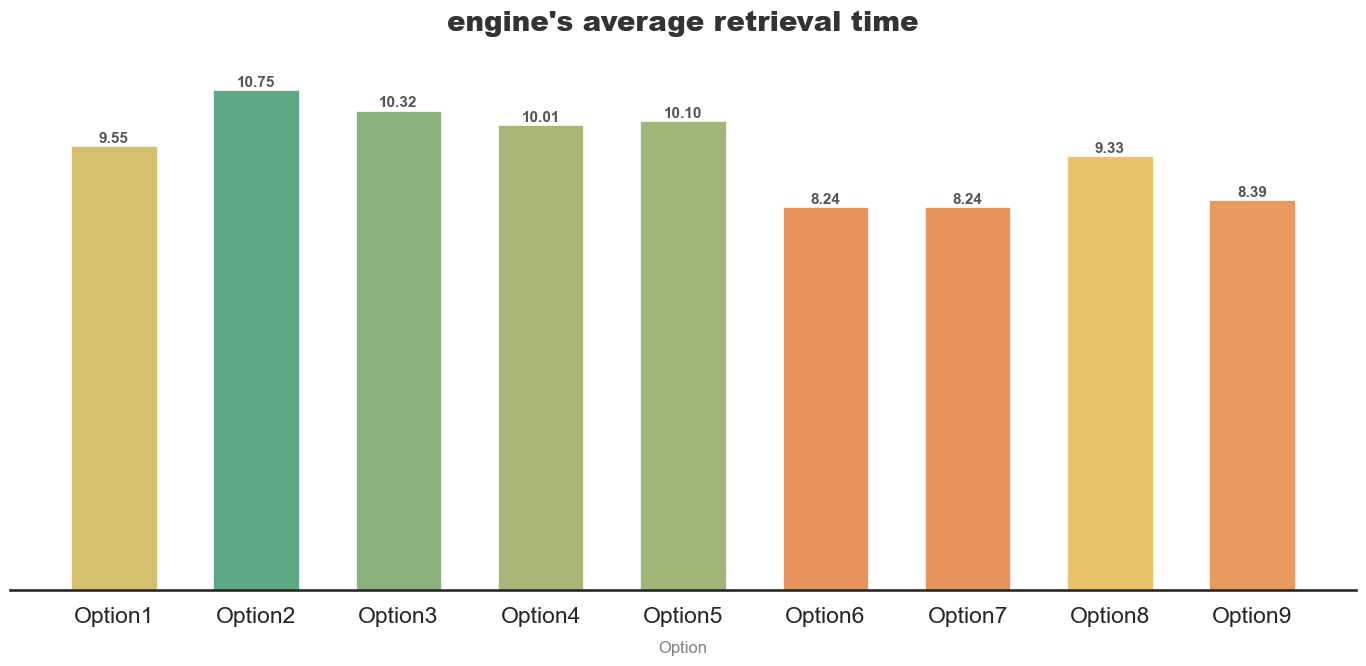

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

def plot_quality_scores_modern(scores_list):
    """
    Creates a premium visualization for a short list of latency scores.
    """
    # data setup
    x_labels = [f'Option{i+1}' for i in range(len(scores_list))]
    df = pd.DataFrame({'Query': x_labels, 'Score': scores_list})
    
    sns.set_theme(style="white", context="talk")
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Custom Color Map: Red (Slow) -> Yellow (Moderate) -> Teal (Fast/Optimal)
    cmap = LinearSegmentedColormap.from_list("custom_quality", ["#e76f51", "#e9c46a", "#2a9d8f"])
    
    norm = plt.Normalize(min(scores_list) * 0.9, max(scores_list) * 1.05)
    colors = [cmap(norm(value)) for value in scores_list]
    bars = ax.bar(df['Query'], df['Score'], color=colors, width=0.6, edgecolor='white', linewidth=0.5)


    # Display the exact duration (seconds) above each bar to 2 decimal places
    for bar, score in zip(bars, scores_list):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{score:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='#555555')

    sns.despine(left=True, bottom=False)
    plt.title("engine's average retrieval time", fontsize=20, fontweight='heavy', color='#333333', pad=25)
    plt.ylabel('Duration(Seconds)', fontsize=12, labelpad=10, color='gray')
    plt.xlabel('Option', fontsize=12, labelpad=10, color='gray')
    ax.yaxis.set_visible(False)

    plt.tight_layout()
    return plt

# Calculate Average Latency per version
scores = []
for result in results:
    # element[1] corresponds to the 'duration' (time) calculated in the get_results function
    rq = [element[1] for element in result]
    scores.append(sum(rq) / len(rq))
plt_obj = plot_quality_scores_modern(scores)
plt_obj.show()